In [2]:
import torch
from environment_batched import BatchedMarket, BatchedLeontief, BatchedFirm, BatchedEnvironment
from models.policy import BetaPolicyNetwork, DeterministicPolicyNetwork, BetaPolicyNetwork2
from models.critic import CentralizedCritic, CentralizedCritic2
from models.utils import get_state, get_state_dim, process_actions, get_action_dim
from trainer import TrainerAC, TrainerSAC, Trainer3
from utils.plotting import plot_actions, plot_environment

In [3]:
torch.manual_seed(123)
torch.backends.cudnn.deterministic = True
device = 'cuda'
market_kwargs = dict(start_volumes=2,
                     base_price=100,
                     start_gains=100,
                     deprecation_steps=2,
                     max_price=100)
prod_functions = [
    BatchedLeontief(torch.tensor([1, 0]), torch.tensor([0, 2]), device=device),
    BatchedLeontief(torch.tensor([0, 1]), torch.tensor([2, 0]), device=device),
]
invest_functions = [
    BatchedLeontief(torch.tensor([1, 1]), torch.tensor(1), device=device),
    BatchedLeontief(torch.tensor([1, 1]), torch.tensor(1), device=device),
]
env = BatchedEnvironment(market_kwargs,
                         BetaPolicyNetwork2,
                         prod_functions,
                         invest_functions=invest_functions,
                         batch_size=1)
critic = CentralizedCritic2
trainer = TrainerSAC(env, q_critic=critic, batch_size=512, buffer_size=1048576 * 8)

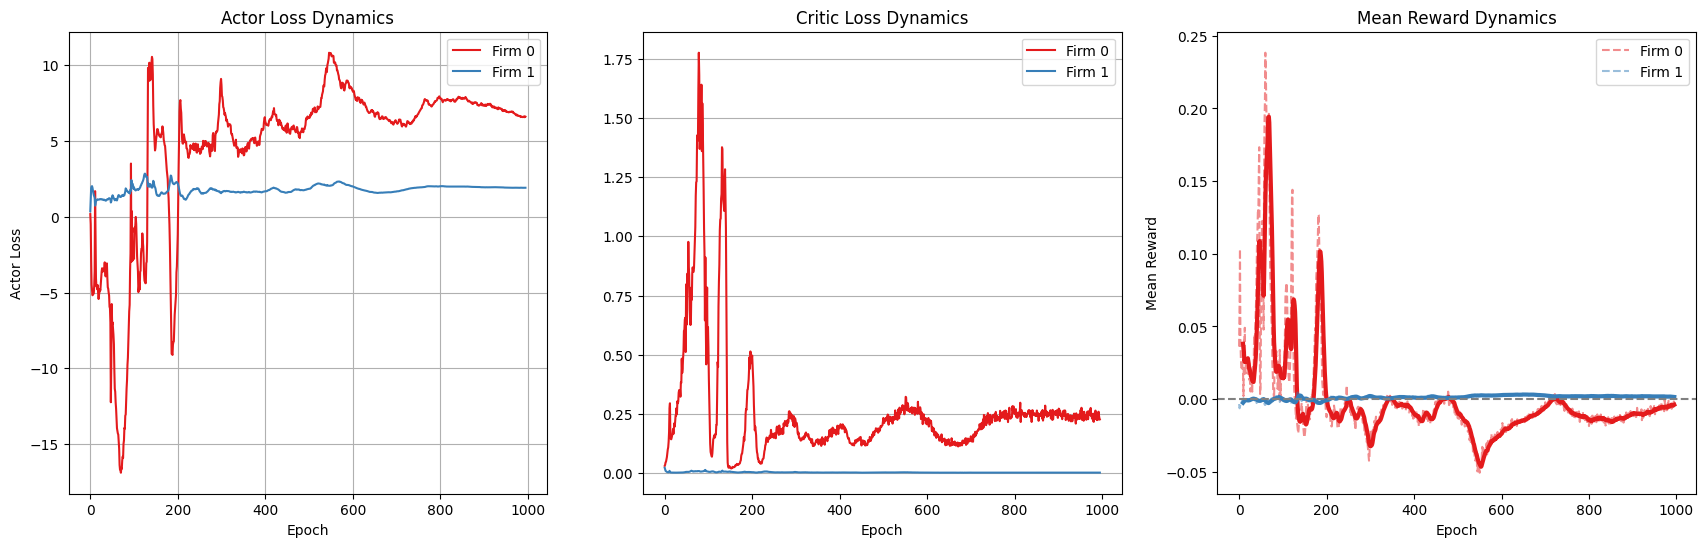

100%|████████████████████████████████████████████████████████████| 1000/1000 [24:12<00:00,  1.45s/it, LR=1.99619057364959e-06, Buffer Index=868352]


In [4]:
env.change_batch_size(1024)
env.reset()
trainer.train(1000, episode_length=50)

In [11]:
env = trainer.environment
env.reset()
env.change_batch_size(1)

In [12]:
n_periods = 30
for i in range(1, n_periods):
    env.step_and_record(i % env.market.n_firms)
# env.firms

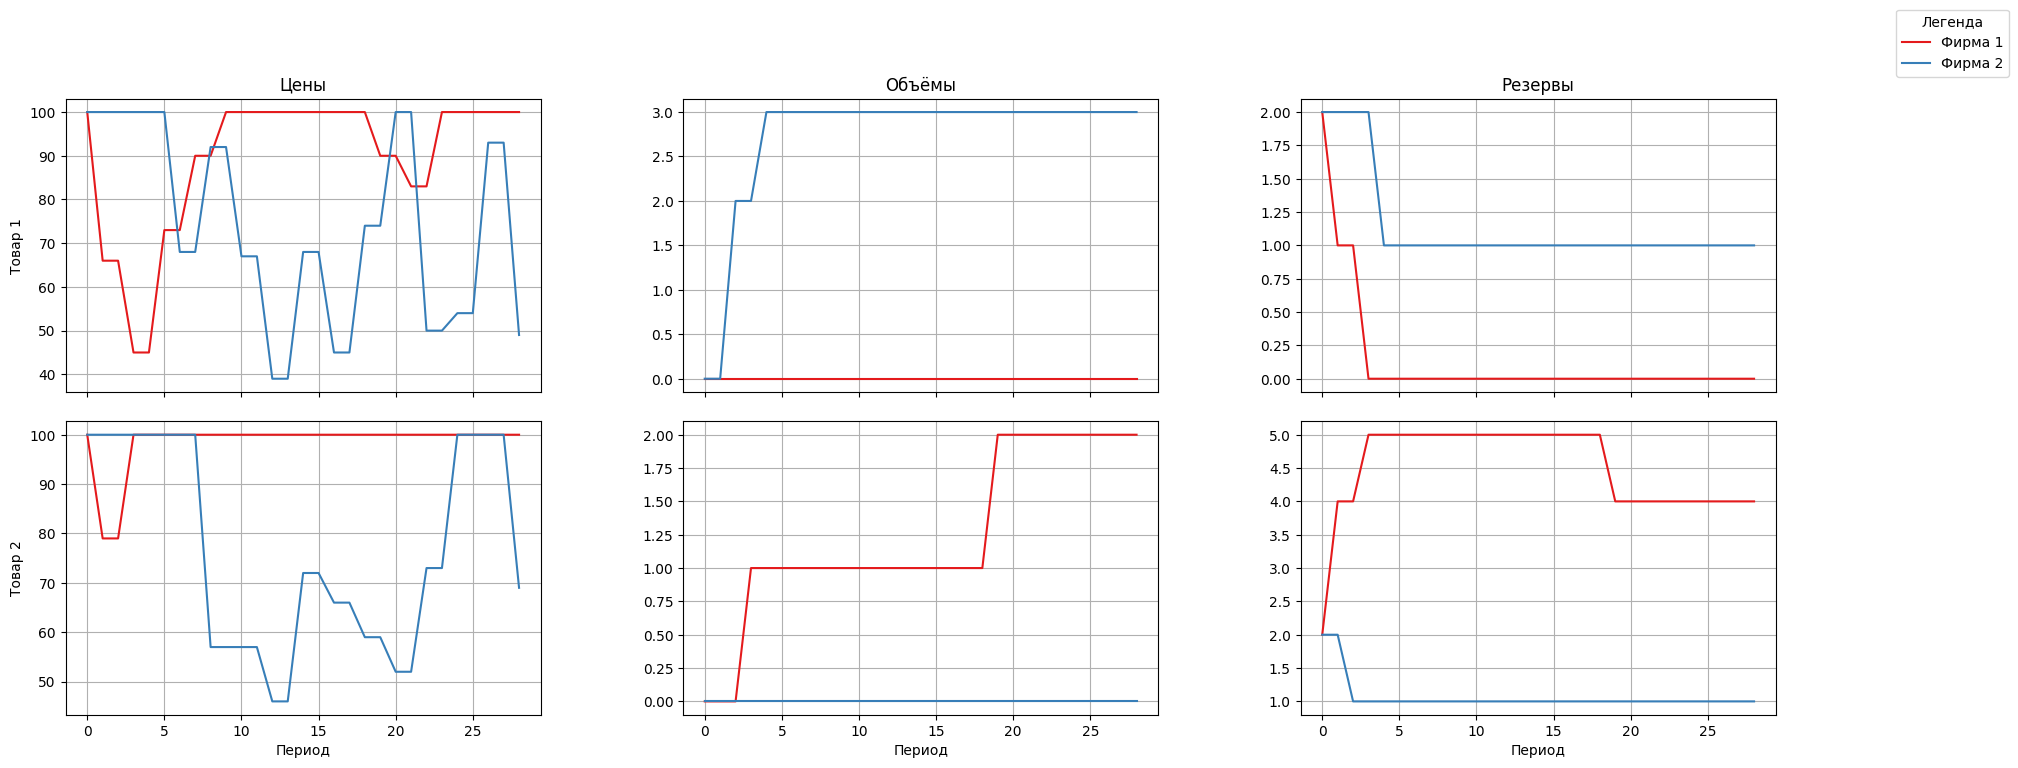

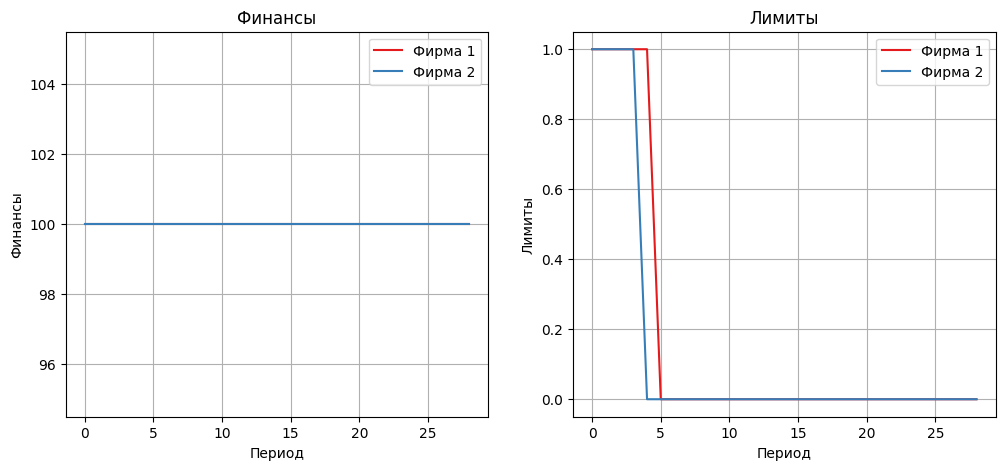

In [13]:
from utils.plotting import plot_actions, plot_environment

plot_environment(env.state_history)

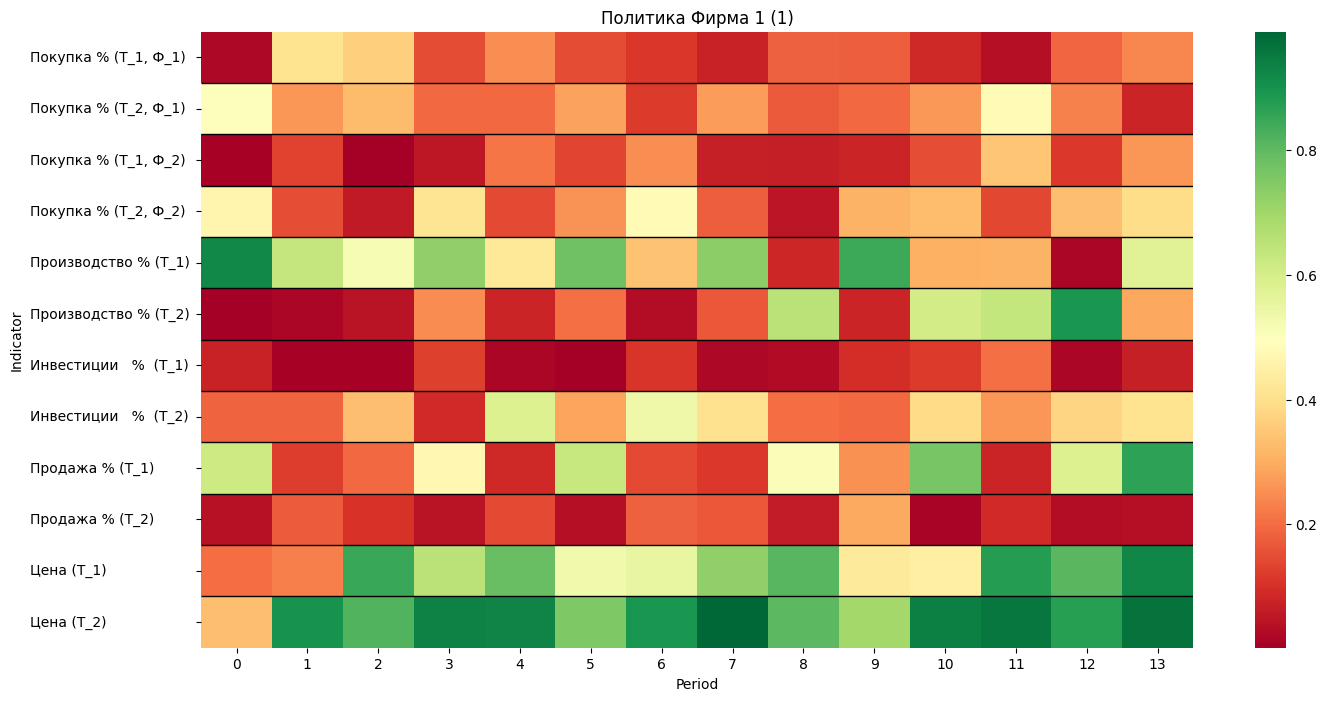

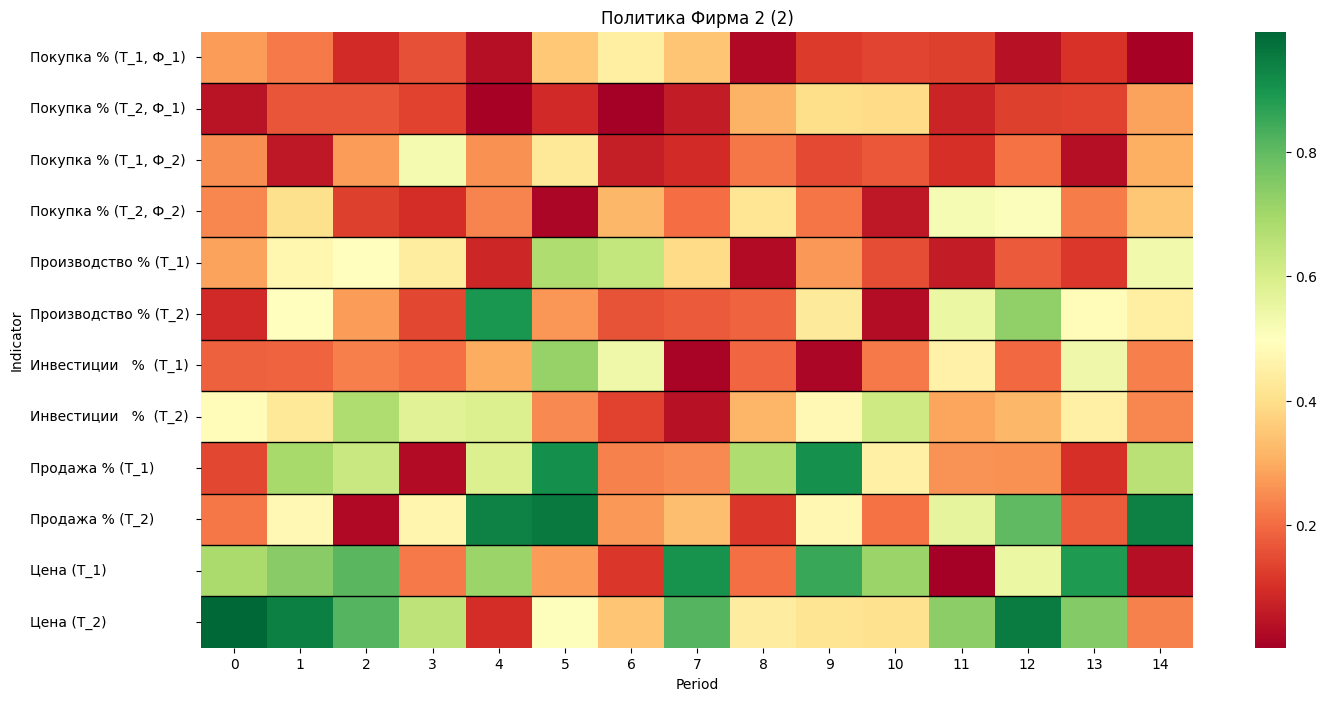

In [14]:
plot_actions(env.actions_history[0], 'Политика Фирма 1 (1)')
plot_actions(env.actions_history[1], 'Политика Фирма 2 (2)')